In [1]:
import QUANTAXIS as QA
import sys


In [2]:
Account=QA.QA_Account(allow_sellopen=True,init_cash=10000,allow_t0=True,account_cookie='future_test',market_type=QA.MARKET_TYPE.FUTURE_CN,frequence=QA.FREQUENCE.FIFTEEN_MIN)

In [3]:
Broker=QA.QA_BacktestBroker()

In [4]:
rb_ds=QA.QA_fetch_future_min_adv('RBL8','2018-01-01','2018-01-30',frequence='60min')

In [5]:
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

ind=rb_ds.add_func(MACD_JCSC)


In [6]:
_date = None
for items in rb_ds.panel_gen:
    if _date != items.date[0]:
        print('try to settle')
        _date=items.date[0]
        Account.settle()
    
    
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0]>0:
            order=Account.send_order(
                code=item.code[0], 
                time=item.datetime[0], 
                amount=1, 
                towards=QA.ORDER_DIRECTION.BUY_OPEN, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )

            if order:
                print(order)
                print(item)
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
        elif daily_ind.CROSS_SC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order=Account.send_order(
                    code=item.code[0], 
                    time=item.datetime[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL_CLOSE, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                if order:
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    Account.settle()
            

try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
< QA_Order realorder_id Order_2GOMToa5 datetime:2018-01-16 10:00:00 code:RBL8 amount:1 price:0 towards:2 btype:future_cn order_id:Order_2GOMToa5 account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
try to settle
try to settle
try to settle
receive deal
try to settle
try to settle
try to settle
< QA_Order realorder_id Order_mS1l3HL2 datetime:2018-01-25 10:00:00 code:RBL8 amount:1 price:0 towards:2 btype:future_cn order_id:Order_mS1l3HL2 account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
receive deal
try to settle
try to settle


In [7]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message
0,2018-01-16 10:00:00,RBL8,3828.0,1,6171.043000,Order_2GOMToa5,Order_2GOMToa5,Trade_yBz1nKDg,future_test,0.957000,0,None
1,2018-01-22 23:00:00,RBL8,3916.5,-1,10086.563875,Order_2saOWLFB,Order_2saOWLFB,Trade_iUp3KEwZ,future_test,0.979125,0,None
2,2018-01-25 10:00:00,RBL8,3959.0,1,6126.574125,Order_mS1l3HL2,Order_mS1l3HL2,Trade_WUnc1JwD,future_test,0.989750,0,None
3,2018-01-26 10:00:00,RBL8,3946.5,-1,10072.087500,Order_Y67soCPe,Order_Y67soCPe,Trade_3YCMN4fJ,future_test,0.986625,0,None


In [8]:
88.5 -1.936125

86.563875

In [9]:
"""
初始资金10000

买入 3828.0  手续费 0.957

可用资金为:  10000 - 3828.0 -0.957 = 6171.043

买入==冻结正常


卖出(平多仓)
3916.5 卖出  手续费 0.979125

结算出  赚(3916.5-3828.0)=88.5 价差 手续费 0.957+0.979125 =1.936125
合计赚 88.5 -1.936125 =86.563875

正确 


当前资金  	10086.563875




"""

'\n初始资金10000\n\n买入 3828.0  手续费 0.957\n\n可用资金为:  10000 - 3828.0 -0.957 = 6171.043\n\n买入==冻结正常\n\n\n卖出(平多仓)\n3916.5 卖出  手续费 0.979125\n\n结算出  赚(3916.5-3828.0)=88.5 价差 手续费 0.957+0.979125 =1.936125\n合计赚 88.5 -1.936125 =86.563875\n\n正确 \n\n\n当前资金  \t10086.563875\n\n\n\n\n'

In [10]:
rb_dayds=QA.QA_fetch_future_day_adv('RBL8','2018-01-01','2018-08-28')


In [11]:
Risk=QA.QA_Risk(Account,if_fq=False,market_data=rb_dayds)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

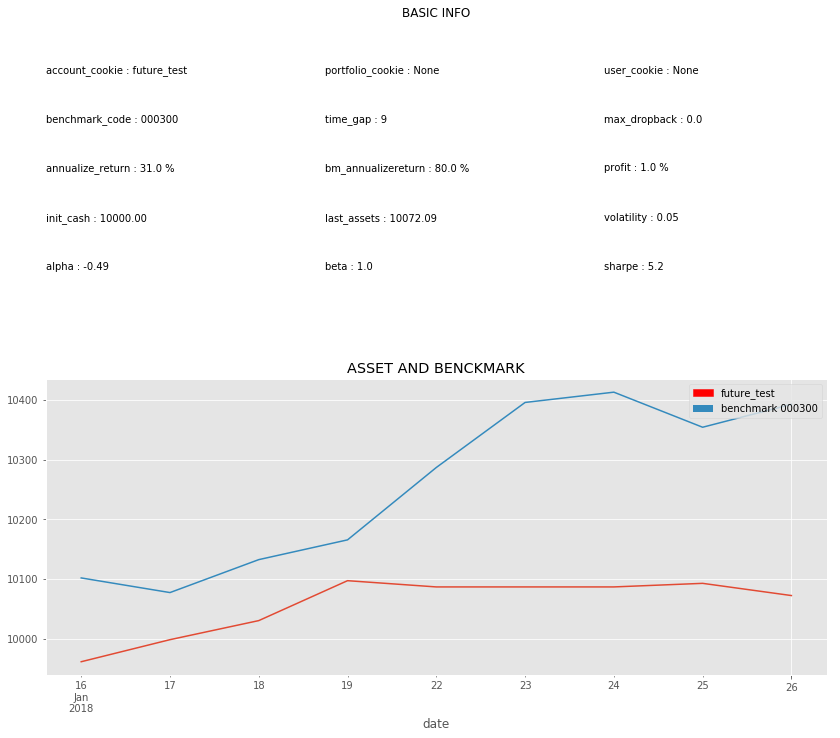

In [12]:
Risk.plot_assets_curve()

In [13]:
Risk.profit_construct

{'total_buyandsell': 76.0,
 'total_tax': 0.0,
 'total_commission': -3.91,
 'total_profit': 72.09}

In [14]:
Account=QA.QA_Account(allow_sellopen=True,init_cash=10000,allow_t0=True,account_cookie='future_test',market_type=QA.MARKET_TYPE.FUTURE_CN,frequence=QA.FREQUENCE.FIFTEEN_MIN)
rb_ds=QA.QA_fetch_future_min_adv('RBL8','2018-01-01','2018-01-30',frequence='60min')
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

ind=rb_ds.add_func(MACD_JCSC)

In [15]:
_date = None
for items in rb_ds.panel_gen:
    if _date != items.date[0]:
        print('try to settle')
        _date=items.date[0]
        Account.settle()
    
    
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_SC.iloc[0]>0:
            order=Account.send_order(
                code=item.code[0], 
                time=item.datetime[0], 
                amount=1, 
                towards=QA.ORDER_DIRECTION.SELL_OPEN, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )

            if order:
                print(order)
                print(item)
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
        elif daily_ind.CROSS_JC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)<0:
                print(1)
                order=Account.send_order(
                    code=item.code[0], 
                    time=item.datetime[0], 
                    amount=abs(Account.sell_available.get(item.code[0], 0)), 
                    towards=QA.ORDER_DIRECTION.BUY_CLOSE, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                if order:
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    Account.settle()

try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
< QA_Order realorder_id Order_ql1PWScR datetime:2018-01-11 23:00:00 code:RBL8 amount:1 price:0 towards:-2 btype:future_cn order_id:Order_ql1PWScR account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
try to settle
try to settle
1
receive deal
try to settle
try to settle
try to settle
try to settle
< QA_Order realorder_id Order_PleM5thI datetime:2018-01-22 23:00:00 code:RBL8 amount:1 price:0 towards:-2 btype:future_cn order_id:Order_PleM5thI account:future_test status:queued >
< QA_DataStruct_Future_min with 1 securities >
receive deal
try to settle
try to settle
try to settle
1
receive deal
try to settle
< QA_Order realorder_id Order_sDAZdh3u datetime:2018-01-26 10:00:00 code:RBL8 amount:1 price:0 towards:-2 btype:future_cn order_id:Order_sDAZdh3u account:future_test status:queued >
< QA_DataStruct_Future_min with 1 secu

In [16]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message
0,2018-01-11 23:00:00,RBL8,3811.0,-1,6188.047250,Order_ql1PWScR,Order_ql1PWScR,Trade_rZRbPdB6,future_test,0.952750,0,None
1,2018-01-16 10:00:00,RBL8,3817.5,1,9989.687375,Order_VLGB8UTf,Order_VLGB8UTf,Trade_q6TkQIbh,future_test,0.954375,0,None
2,2018-01-22 23:00:00,RBL8,3914.0,-1,6074.708875,Order_PleM5thI,Order_PleM5thI,Trade_PrQ03wG7,future_test,0.978500,0,None
3,2018-01-25 10:00:00,RBL8,3952.0,1,9947.763875,Order_RzyJFOYp,Order_RzyJFOYp,Trade_QMqKvcCX,future_test,0.988000,0,None
4,2018-01-26 10:00:00,RBL8,3934.0,-1,6012.780375,Order_sDAZdh3u,Order_sDAZdh3u,Trade_Juyh0EKN,future_test,0.983500,0,None


In [17]:
10000-6.5-1.907125


9991.592875

In [18]:
"""
初始资金10000


卖空开仓:3811.0 手续费 0.952750

冻结资金 3811.95275
应剩余 6188.04725 


买入平仓 	3817.5	 手续费0.954375

买卖盈亏(3811.0-3817.5) = -6.5 手续费合计1.907125

应剩余资金 10000-6.5-1.907125 = 9991.592875  ==> 恢复后依然正确




"""

'\n初始资金10000\n\n\n卖空开仓:3811.0 手续费 0.952750\n\n冻结资金 3811.95275\n应剩余 6188.04725  ==> 此处冻结错误\n\n\n买入平仓 \t3817.5\t 手续费0.954375\n\n买卖盈亏(3811.0-3817.5) = -6.5 手续费合计1.907125\n\n应剩余资金 10000-6.5-1.907125 = 9991.592875  ==> 恢复后依然正确\n\n\n\n\n'